# Facebook Link prediction
- Given a directed social graph, have to predict missing link for the purpose of recommending users.

*Let's start by importing some basic libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv
import math

*Not the entire data is loaded due to limited computational resources.*

In [2]:
train = pd.read_csv('train.csv', nrows = 1000000)

*Carrying out some basic data inspection*

In [3]:
train.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [4]:
train.shape

(1000000, 2)

- The idea is to map the above data into a binary classification problem as:
  - *If there is a link between source_node and destination_node; label it as 1*
  - *If there shouldn't be a link between the two nodes; label it as 0*


In [5]:
train.to_csv('train_wh.csv', header = False, index = False)

In [6]:
g = nx.read_edgelist('train_wh.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 685775
Number of edges: 1000000
Average in degree:   1.4582
Average out degree:   1.4582


Conducting some *Exploratory Data Analysis* as follows.

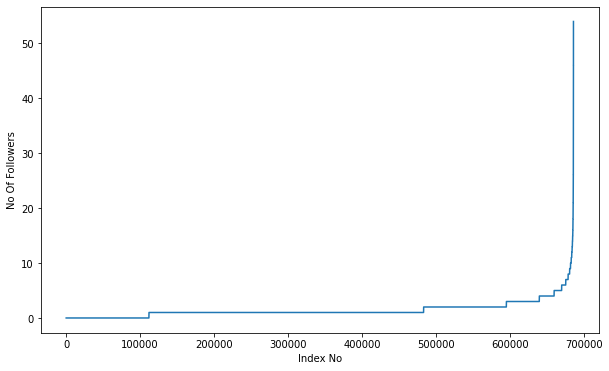

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

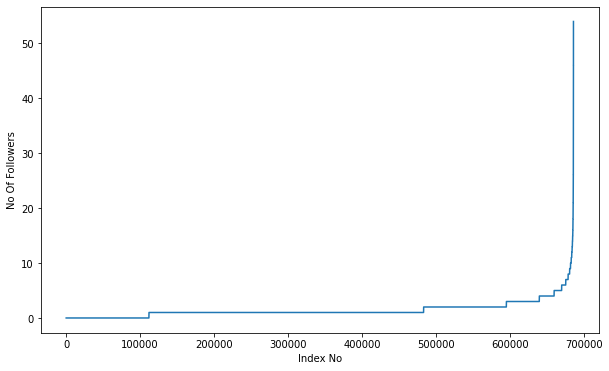

In [8]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

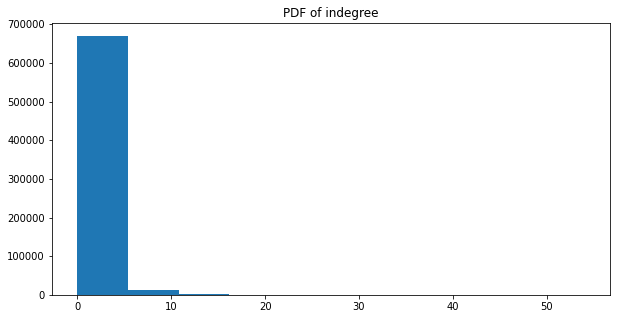

In [9]:
plt.figure(figsize = (10, 5))
plt.hist(x = indegree_dist)
plt.title('PDF of indegree')
plt.show()

- An overwhelming number of people have indegree beween 0 and 15, with a major portion having it to be 0.

*Let's also now evalute the out degree*

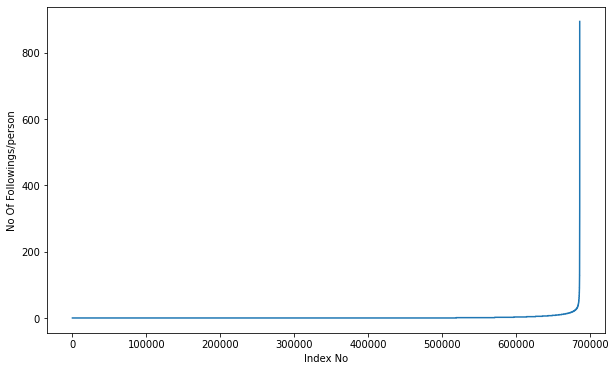

In [10]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followings/person')
plt.show()

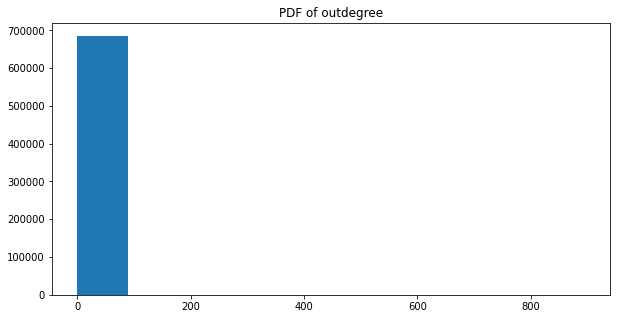

In [11]:
plt.figure(figsize = (10, 5))
plt.hist(x = outdegree_dist)
plt.title('PDF of outdegree')
plt.show()

- An overwhelming number of people follow others in the range of 0 to 200.

In [12]:
no_in_cnt = 0
no_out_cnt = 0

for i in indegree_dist:
  if i == 0:
    no_in_cnt += 1

for i in outdegree_dist:
  if i == 0:
    no_out_cnt += 1

In [13]:
print("No. of people who have no followers/indegree: {}...({}%)".format(no_in_cnt, no_in_cnt*100/len(indegree_dist)))
print("No. of people who don't follow anyone/outdegree: {}...({})%".format(no_out_cnt, no_out_cnt*100/len(outdegree_dist)))

No. of people who have no followers/indegree: 111814...(16.304764682293754%)
No. of people who don't follow anyone/outdegree: 518757...(75.64536473333091)%


In [14]:
cnt = 0
for i in g.nodes():
  if len(list(g.predecessors(i))) == 0:
    if len(list(g.successors(i))) == 0:
      cnt += 1
print('No. of people with no followers/followees is {}'.format(cnt))

No. of people with no followers/followees is 0


*Generating some edges which are not present in the graph*

In [15]:
r = csv.reader(open('train_wh.csv', 'r'))
present_edges = {}
for i in r:
  present_edges[(int(i[0]), int(i[1]))] = 1

In [16]:
for i in range(train.shape[0]):
  a = np.random.randint(1, 685775)
  b = np.random.randint(1, 685775)
  if present_edges.get((a, b)) == None and a != b:
    present_edges[(a, b)] = 0

In [19]:
s_key = []
d_key = []
for i in present_edges.keys():
  s_key.append(i[0])
  d_key.append(i[1])

In [20]:
df_edges = pd.DataFrame(s_key, columns=['source'])
df_edges['destination'] = d_key
df_edges['edge'] = list(present_edges.values())

In [21]:
df_edges.head()

,source,destination,edge
0,1,690569,1
1,1,315892,1
2,1,189226,1
3,2,834328,1
4,2,1615927,1


*Now that, the information of* presence (1) *or* absence (0) *of edges has been determined, let's try to engineer some features.*

### 1. Jaccard Similarity

In [22]:
def jaccard_similarity_followers(a, b):
  try:
    if len(set(g.predecessors(a))) == 0 | len(set(g.predecessors(b))) == 0:
      return 0
    else:
      jac_sim = len(set(g.predecessors(a)).intersection(g.predecessors(b)))/len(set(g.predecessors(a)).union(g.predecessors(b)))
      return jac_sim
  except:
      return 0

In [23]:
def jaccard_similarity_followees(a, b):
  try:
    if len(set(g.successors(a))) == 0 | len(set(g.successors(b))) == 0:
      return 0
    else:
      jac_sim = len(set(g.successors(a)).intersection(g.successors(b)))/len(set(g.successors(a)).union(g.successors(b)))
      return jac_sim
  except:
      return 0  

In [24]:
df_edges['jac_sim_followers'] = df_edges[['source', 'destination']].apply(lambda x : jaccard_similarity_followers(x['source'], x['destination']), axis = 1)
df_edges['jac_sim_followees'] = df_edges[['source', 'destination']].apply(lambda x : jaccard_similarity_followees(x['source'], x['destination']), axis = 1)

In [25]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees
0,1,690569,1,0.333333,0.000000
1,1,315892,1,0.000000,0.000000
2,1,189226,1,0.000000,0.166667
3,2,834328,1,0.000000,0.000000
4,2,1615927,1,0.000000,0.000000


### 2. Cosine Distance

In [26]:
def cosine_followees(a, b):
  try:
    if len(set(g.successors(a))) == 0 | len(set(g.successors(b))) == 0:
      return 0
    else:
      cos_sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
      return cos_sim
  except:
    return 0

def cosine_followers(a, b):
  try:
    if len(set(g.predecessors(a))) == 0 | len(set(g.predecessors(b))) == 0:
      return 0
    else:
      cos_sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(math.sqrt(len(set(g.predecessors(a))))*(len(set(g.predecessors(b)))))
      return cos_sim
  except:
    return 0

In [27]:
df_edges['cos_sim_followers'] = df_edges[['source', 'destination']].apply(lambda x : cosine_followers(x['source'], x['destination']), axis = 1)
df_edges['cos_sim_followees'] = df_edges[['source', 'destination']].apply(lambda x : cosine_followees(x['source'], x['destination']), axis = 1)

In [28]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees,cos_sim_followers,cos_sim_followees
0,1,690569,1,0.333333,0.000000,0.333333,0.000000
1,1,315892,1,0.000000,0.000000,0.000000,0.000000
2,1,189226,1,0.000000,0.166667,0.000000,0.288675
3,2,834328,1,0.000000,0.000000,0.000000,0.000000
4,2,1615927,1,0.000000,0.000000,0.000000,0.000000


### 3. Shortest Path
- If two nodes have an edge, then I will be deleteing the edge and then calculating the shortest path.

In [35]:
def shortest_path(a, b):
  p = -1
  try:
    if g.has_edge(a, b):
      g.remove_edge(a, b)
      p = nx.shortest_path_length(g, a, b)
      g.add_edge(a, b)
      return p
    else:
      p = nx.shortest_path_length(g, a, b)
      return p
  except:
    return p

In [36]:
df_edges['shortest_path'] = df_edges[['source', 'destination']].apply(lambda x : shortest_path(x['source'], x['destination']), axis = 1)

In [53]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees,cos_sim_followers,cos_sim_followees,shortest_path
0,1,690569,1,0.333333,0.000000,0.333333,0.000000,2
1,1,315892,1,0.000000,0.000000,0.000000,0.000000,-1
2,1,189226,1,0.000000,0.166667,0.000000,0.288675,-1
3,2,834328,1,0.000000,0.000000,0.000000,0.000000,-1
4,2,1615927,1,0.000000,0.000000,0.000000,0.000000,-1


### 4. Adar Index

In [60]:
def adar_index(a, b):
  sum = 0
  try:
    n = list(set(g.successors(a)).intersection(set(g.successors(b))))
    if len(n)!=0:
        for i in n:
            sum=sum+(1/np.log10(len(list(g.predecessors(i)))))
        return sum
    else:
        return 0
  except:
    return 0

In [61]:
df_edges['adar_index'] = df_edges[['source', 'destination']].apply(lambda x : adar_index(x['source'], x['destination']), axis = 1)

In [62]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees,cos_sim_followers,cos_sim_followees,shortest_path,adar_index
0,1,690569,1,0.333333,0.000000,0.333333,0.000000,2,0.000000
1,1,315892,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000
2,1,189226,1,0.000000,0.166667,0.000000,0.288675,-1,3.321928
3,2,834328,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000
4,2,1615927,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000


### 5. Following back or not

In [63]:
def follows_back(a, b):
  if g.has_edge(b, a):
    return 1
  else:
    return 0

In [64]:
df_edges['follows_back'] = df_edges[['source', 'destination']].apply(lambda x : follows_back(x['source'], x['destination']), axis = 1)

In [65]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees,cos_sim_followers,cos_sim_followees,shortest_path,adar_index,follows_back
0,1,690569,1,0.333333,0.000000,0.333333,0.000000,2,0.000000,0
1,1,315892,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0
2,1,189226,1,0.000000,0.166667,0.000000,0.288675,-1,3.321928,0
3,2,834328,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0
4,2,1615927,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0


### 6. Katz Centrality

In [136]:
katz = nx.katz.katz_centrality(g, alpha=0.005, beta=1)

In [139]:
mean_katz = sum(katz.values())/len(katz)

In [140]:
df_edges['katz_source'] = df_edges['source'].apply(lambda x : katz.get(x, mean_katz))
df_edges['katz_destination'] = df_edges['destination'].apply(lambda x : katz.get(x, mean_katz))

In [141]:
df_edges.head()

,source,destination,edge,jac_sim_followers,jac_sim_followees,cos_sim_followers,cos_sim_followees,shortest_path,adar_index,follows_back,katz_source,katz_destination
0,1,690569,1,0.333333,0.000000,0.333333,0.000000,2,0.000000,0,0.001206,0.001218
1,1,315892,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0,0.001206,0.001206
2,1,189226,1,0.000000,0.166667,0.000000,0.288675,-1,3.321928,0,0.001206,0.001206
3,2,834328,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0,0.001206,0.001212
4,2,1615927,1,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0,0.001206,0.001206


## Model Building
- Splitting the data into train and test
- Training the model

In [142]:
from sklearn.model_selection import train_test_split
X = df_edges.drop(['source', 'destination', 'edge'], axis = 1)
y = df_edges['edge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

#### Logistic Regression

In [149]:
from sklearn.linear_model import SGDClassifier

logreg = SGDClassifier(loss = 'log')
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [152]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

Train accuracy:  0.6466941167352919
Test accuracy:  0.6465566163915409


In [153]:
print('Train F1 score: ', f1_score(y_train, y_train_pred))
print('Test F1 score: ', f1_score(y_test, y_test_pred))

Train F1 score:  0.45369500593381196
Test F1 score:  0.4533725133875925


#### SVC

In [154]:
logreg = SGDClassifier(loss = 'hinge')
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [155]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('Train F1 score: ', f1_score(y_train, y_train_pred))
print('Test F1 score: ', f1_score(y_test, y_test_pred))

Train accuracy:  0.6438097345243363
Test accuracy:  0.6437741094352736
Train F1 score:  0.44676755331593093
Test F1 score:  0.44668804995301375


#### Decision Tree Classifier

In [156]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

In [157]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('Train F1 score: ', f1_score(y_train, y_train_pred))
print('Test F1 score: ', f1_score(y_test, y_test_pred))

Train accuracy:  0.8895684739211848
Test accuracy:  0.8897222243055608
Train F1 score:  0.9005287418960396
Test F1 score:  0.900639935488376


In [158]:
print(confusion_matrix(y_train, y_train_pred))
print('=======================================')
print(confusion_matrix(y_test, y_test_pred))

[[623505 176491]
 [   199 799801]]
[[155968  44031]
 [    80 199920]]


- The performance of Decision Tree is certainly much better tahn the other two models.
- The performance is obtained even without hyper-parameter tuning.

#### Random Forest Classifier

In [159]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [160]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('Train F1 score: ', f1_score(y_train, y_train_pred))
print('Test F1 score: ', f1_score(y_test, y_test_pred))

Train accuracy:  0.8895503488758721
Test accuracy:  0.889769724424311
Train F1 score:  0.900520312333761
Test F1 score:  0.9006901149590976


In [161]:
print(confusion_matrix(y_train, y_train_pred))
print('=======================================')
print(confusion_matrix(y_test, y_test_pred))

[[623420 176576]
 [   143 799857]]
[[155961  44038]
 [    54 199946]]


- Again, a very good performance obtained.

Neural Network model

In [162]:
import keras
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model

In [173]:
input_layer = Input(shape = (len(X_train.columns),))
dense_1 = Dense(32, activation = 'relu')(input_layer)
dense_2 = Dense(64, activation = 'relu')(dense_1)
dense_3 = Dense(124, activation = 'relu')(dense_2)
dense_4 = Dense(32, activation = 'relu')(dense_3)
output_layer = Dense(1, activation = 'sigmoid')(dense_4)

dl_model = Model(inputs = [input_layer], outputs = [output_layer])

In [174]:
dl_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 124)               8060      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4000      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 14,525
Trainable params: 14,525
Non-trainable params: 0
_______________________________________________________

In [175]:
dl_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = dl_model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 30, validation_split = 0.05)

Epoch 1/30
11875/11875 [==============================] - 29s 2ms/step - loss: 0.5813 - accuracy: 0.6464 - val_loss: 0.5770 - val_accuracy: 0.6495
Epoch 2/30
11875/11875 [==============================] - 27s 2ms/step - loss: 0.5783 - accuracy: 0.6481 - val_loss: 0.5769 - val_accuracy: 0.6495
Epoch 3/30
11875/11875 [==============================] - 26s 2ms/step - loss: 0.5786 - accuracy: 0.6472 - val_loss: 0.5770 - val_accuracy: 0.6495
Epoch 4/30
11875/11875 [==============================] - 26s 2ms/step - loss: 0.5783 - accuracy: 0.6476 - val_loss: 0.5769 - val_accuracy: 0.6495
Epoch 5/30
11875/11875 [==============================] - 27s 2ms/step - loss: 0.5789 - accuracy: 0.6467 - val_loss: 0.5770 - val_accuracy: 0.6495
Epoch 6/30
11875/11875 [==============================] - 27s 2ms/step - loss: 0.5782 - accuracy: 0.6473 - val_loss: 0.5770 - val_accuracy: 0.6495
Epoch 7/30
11875/11875 [==============================] - 29s 2ms/step - loss: 0.5786 - accuracy: 0.6471 - val_loss: 0

In [178]:
y_train_pred = dl_model.predict(X_train)
y_train_pred = y_train_pred.reshape(1599996)

In [183]:
y_test_pred = dl_model.predict(X_test)
y_test_pred = y_test_pred.reshape(399999)

- *Both the predictions on train as well as test data are in terms of probability*
  - Taking 0.5 as thresh as follows

In [191]:
y_train_pred_c = pd.Series(y_train_pred).apply(lambda x : 1 if x >= 0.5 else 0).values
y_test_pred_c = pd.Series(y_test_pred).apply(lambda x : 1 if x >= 0.5 else 0).values

In [192]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred_c))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred_c))
print('Train F1 score: ', f1_score(y_train, y_train_pred_c))
print('Test F1 score: ', f1_score(y_test, y_test_pred_c))

Train accuracy:  0.6475384938462346
Test accuracy:  0.6473866184665462
Train F1 score:  0.45571127855542753
Test F1 score:  0.4553553155421347


## Conclusion
- Best performance has come from Tree based models (Decision Tree and Random Forest).